In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf

data_path = "../../../cc2ai/ethen/"
postfix = "_ethen_6-31g**"
dim = 48
N_ELECTRONS = 16
basis = "6-31g**"
#data_path = "../../dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
#S = np.load(join(data_path, "S" + postfix + ".npy"))
#P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)

# Utilities 

In [3]:
def fock_from_density(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

f_test = fock_from_density(p_test)

In [4]:
from pyscf.scf import hf

def density_from_fock(f, s, mol):
    
    mo_energy, mo_coeff = hf.eig(f, s)
    mo_occ = hf.get_occ(mf=hf.SCF(mol), mo_energy=mo_energy, mo_coeff=mo_coeff)
    
    return hf.make_rdm1(mo_coeff, mo_occ)

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)

In [5]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [6]:
f_test.shape

(40, 48, 48)

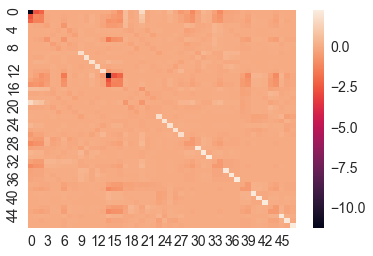

In [7]:
import seaborn as sns

sns.heatmap(f_test[0].reshape(dim, dim))

In [8]:
p_test_test = density_from_fock_batch(f_test)

In [9]:
np.mean(np.abs(p_test.flatten() - p_test_test.flatten()))

2.6081828286913667e-08

In [10]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities



print(make_results_str(measure_all_quantities(
    p_test_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:18:07: Iteration calculation: 0
[ ] 2018-10-11 19:18:07: Iteration calculation: 1
[ ] 2018-10-11 19:18:08: Iteration calculation: 2
[ ] 2018-10-11 19:18:08: Iteration calculation: 3
[ ] 2018-10-11 19:18:08: Iteration calculation: 4
[ ] 2018-10-11 19:18:08: Iteration calculation: 5
[ ] 2018-10-11 19:18:08: Iteration calculation: 6
[ ] 2018-10-11 19:18:09: Iteration calculation: 7
[ ] 2018-10-11 19:18:09: Iteration calculation: 8
[ ] 2018-10-11 19:18:09: Iteration calculation: 9
[ ] 2018-10-11 19:18:09: Iteration calculation: 10
[ ] 2018-10-11 19:18:09: Iteration calculation: 11
[ ] 2018-10-11 19:18:09: Iteration calculation: 12
[ ] 2018-10-11 19:18:10: Iteration calculation: 13
[ ] 2018-10-11 19:18:10: Iteration calculation: 14
[ ] 2018-10-11 19:18:10: Iteration calculation: 15
[ ] 2018-10-11 19:18:10: Iteration calculation: 16
[ ] 2018-10-11 19:18:10: Iteration calculation: 17
[ ] 2018-10-11 19:18:10: Iteration calculation: 18
[ ] 2018-10-11 19:18:10: Iteration calcul

# Pure blocks

i will now set all other elements zero

## Utilities

In [11]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[0][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

In [12]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0
    return p_batch

f_pure = np.array(list(map(extract_pure, f_test))).astype("float64")

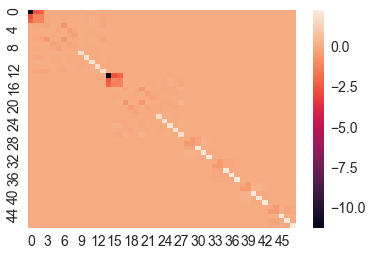

In [14]:
sns.heatmap(f_pure[0])

## Pure Block Analysis 

In [15]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_pure),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:19:52: Iteration calculation: 0
[ ] 2018-10-11 19:19:53: Iteration calculation: 1
[ ] 2018-10-11 19:19:53: Iteration calculation: 2
[ ] 2018-10-11 19:19:53: Iteration calculation: 3
[ ] 2018-10-11 19:19:54: Iteration calculation: 4
[ ] 2018-10-11 19:19:54: Iteration calculation: 5
[ ] 2018-10-11 19:19:55: Iteration calculation: 6
[ ] 2018-10-11 19:19:55: Iteration calculation: 7
[ ] 2018-10-11 19:19:55: Iteration calculation: 8
[ ] 2018-10-11 19:19:56: Iteration calculation: 9
[ ] 2018-10-11 19:19:56: Iteration calculation: 10
[ ] 2018-10-11 19:19:56: Iteration calculation: 11
[ ] 2018-10-11 19:19:57: Iteration calculation: 12
[ ] 2018-10-11 19:19:57: Iteration calculation: 13
[ ] 2018-10-11 19:19:57: Iteration calculation: 14
[ ] 2018-10-11 19:19:58: Iteration calculation: 15
[ ] 2018-10-11 19:19:58: Iteration calculation: 16
[ ] 2018-10-11 19:19:58: Iteration calculation: 17
[ ] 2018-10-11 19:19:58: Iteration calculation: 18
[ ] 2018-10-11 19:19:59: Iteration calcul

# Embedding the Blocks In Classical Guesses

In [16]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(f_batch):
    f_embedded = []
    for (f_guess, f_conv) in zip(f_batch, f_test):
        f_embedded.append(embedd(f_guess, f_conv))
    return np.array(f_embedded)


## Converged in Converged 

In [17]:
f_test_test_test = embedd_batch(f_test)

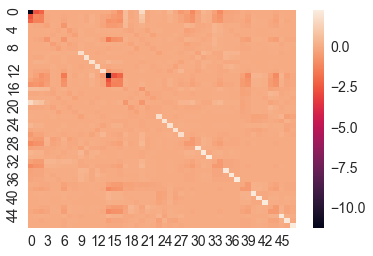

In [18]:
sns.heatmap(f_test_test_test[0])

In [19]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_test_test_test),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:20:33: Iteration calculation: 0
[ ] 2018-10-11 19:20:33: Iteration calculation: 1
[ ] 2018-10-11 19:20:34: Iteration calculation: 2
[ ] 2018-10-11 19:20:34: Iteration calculation: 3
[ ] 2018-10-11 19:20:34: Iteration calculation: 4
[ ] 2018-10-11 19:20:34: Iteration calculation: 5
[ ] 2018-10-11 19:20:34: Iteration calculation: 6
[ ] 2018-10-11 19:20:35: Iteration calculation: 7
[ ] 2018-10-11 19:20:35: Iteration calculation: 8
[ ] 2018-10-11 19:20:35: Iteration calculation: 9
[ ] 2018-10-11 19:20:36: Iteration calculation: 10
[ ] 2018-10-11 19:20:36: Iteration calculation: 11
[ ] 2018-10-11 19:20:36: Iteration calculation: 12
[ ] 2018-10-11 19:20:36: Iteration calculation: 13
[ ] 2018-10-11 19:20:36: Iteration calculation: 14
[ ] 2018-10-11 19:20:37: Iteration calculation: 15
[ ] 2018-10-11 19:20:37: Iteration calculation: 16
[ ] 2018-10-11 19:20:37: Iteration calculation: 17
[ ] 2018-10-11 19:20:37: Iteration calculation: 18
[ ] 2018-10-11 19:20:37: Iteration calcul

## Zeros 

In [20]:
f_test_zeros = embedd_batch(np.zeros(f_test.shape))

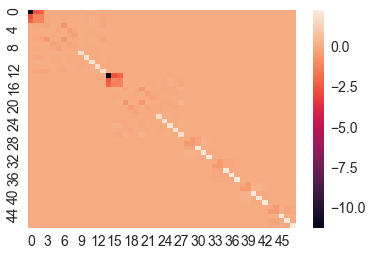

In [21]:
sns.heatmap(f_test_zeros[0])

In [44]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_test_zeros),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:38:31: Iteration calculation: 0
[ ] 2018-10-11 19:38:31: Iteration calculation: 1
[ ] 2018-10-11 19:38:31: Iteration calculation: 2
[ ] 2018-10-11 19:38:32: Iteration calculation: 3
[ ] 2018-10-11 19:38:32: Iteration calculation: 4
[ ] 2018-10-11 19:38:32: Iteration calculation: 5
[ ] 2018-10-11 19:38:33: Iteration calculation: 6
[ ] 2018-10-11 19:38:33: Iteration calculation: 7
[ ] 2018-10-11 19:38:33: Iteration calculation: 8
[ ] 2018-10-11 19:38:33: Iteration calculation: 9
[ ] 2018-10-11 19:38:34: Iteration calculation: 10
[ ] 2018-10-11 19:38:34: Iteration calculation: 11
[ ] 2018-10-11 19:38:34: Iteration calculation: 12
[ ] 2018-10-11 19:38:34: Iteration calculation: 13
[ ] 2018-10-11 19:38:35: Iteration calculation: 14
[ ] 2018-10-11 19:38:35: Iteration calculation: 15
[ ] 2018-10-11 19:38:35: Iteration calculation: 16
[ ] 2018-10-11 19:38:36: Iteration calculation: 17
[ ] 2018-10-11 19:38:36: Iteration calculation: 18
[ ] 2018-10-11 19:38:36: Iteration calcul

# GWH

In [22]:
f_gwh = []

k = np.ones((dim, dim)) * 1.75 - \
            np.diag(np.ones(dim)) * 0.75  

for h,s in zip(h_test, s_test):
    h_diag = np.diag(h)   
        
    f_gwh.append(k * np.add.outer(h_diag, h_diag) * s / 2)
    
f_gwh = np.array(f_gwh)

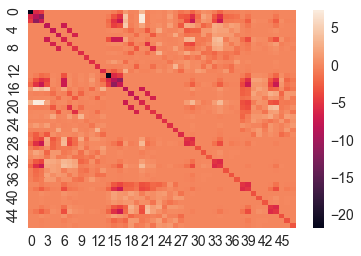

In [23]:
sns.heatmap(f_gwh[0])

In [24]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_gwh),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:22:32: Iteration calculation: 0
[ ] 2018-10-11 19:22:32: Iteration calculation: 1
[ ] 2018-10-11 19:22:32: Iteration calculation: 2
[ ] 2018-10-11 19:22:32: Iteration calculation: 3
[ ] 2018-10-11 19:22:33: Iteration calculation: 4
[ ] 2018-10-11 19:22:33: Iteration calculation: 5
[ ] 2018-10-11 19:22:33: Iteration calculation: 6
[ ] 2018-10-11 19:22:33: Iteration calculation: 7
[ ] 2018-10-11 19:22:33: Iteration calculation: 8
[ ] 2018-10-11 19:22:34: Iteration calculation: 9
[ ] 2018-10-11 19:22:34: Iteration calculation: 10
[ ] 2018-10-11 19:22:35: Iteration calculation: 11
[ ] 2018-10-11 19:22:35: Iteration calculation: 12
[ ] 2018-10-11 19:22:35: Iteration calculation: 13
[ ] 2018-10-11 19:22:36: Iteration calculation: 14
[ ] 2018-10-11 19:22:36: Iteration calculation: 15
[ ] 2018-10-11 19:22:36: Iteration calculation: 16
[ ] 2018-10-11 19:22:37: Iteration calculation: 17
[ ] 2018-10-11 19:22:37: Iteration calculation: 18
[ ] 2018-10-11 19:22:37: Iteration calcul

## EmbeddedGWH 

In [25]:
f_embedded_gwh = embedd_batch(f_gwh)

### Diff Conv vs GWH 

In [26]:
np.mean(np.abs(f_test.flatten() - f_gwh.flatten()))

0.8005335095971629

### Diff Embedded vs gwh

In [27]:
np.mean(np.abs(f_embedded_gwh.flatten() - f_gwh.flatten()))

0.22450454057278588

### Diff Conv vs Embedded 

In [28]:
np.mean(np.abs(f_embedded_gwh.flatten() - f_test.flatten()))

0.576028969024377

### Analysing the density

In [29]:
p_embedded_gwh = density_from_fock_batch(f_embedded_gwh)

In [30]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:24:15: Iteration calculation: 0
[ ] 2018-10-11 19:24:15: Iteration calculation: 1
[ ] 2018-10-11 19:24:16: Iteration calculation: 2
[ ] 2018-10-11 19:24:16: Iteration calculation: 3
[ ] 2018-10-11 19:24:17: Iteration calculation: 4
[ ] 2018-10-11 19:24:17: Iteration calculation: 5
[ ] 2018-10-11 19:24:18: Iteration calculation: 6
[ ] 2018-10-11 19:24:18: Iteration calculation: 7
[ ] 2018-10-11 19:24:18: Iteration calculation: 8
[ ] 2018-10-11 19:24:19: Iteration calculation: 9
[ ] 2018-10-11 19:24:19: Iteration calculation: 10
[ ] 2018-10-11 19:24:20: Iteration calculation: 11
[ ] 2018-10-11 19:24:20: Iteration calculation: 12
[ ] 2018-10-11 19:24:21: Iteration calculation: 13
[ ] 2018-10-11 19:24:21: Iteration calculation: 14
[ ] 2018-10-11 19:24:21: Iteration calculation: 15
[ ] 2018-10-11 19:24:22: Iteration calculation: 16
[ ] 2018-10-11 19:24:22: Iteration calculation: 17
[ ] 2018-10-11 19:24:22: Iteration calculation: 18
[ ] 2018-10-11 19:24:23: Iteration calcul

## SAD

In [31]:
f_sad = fock_from_density(np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]))

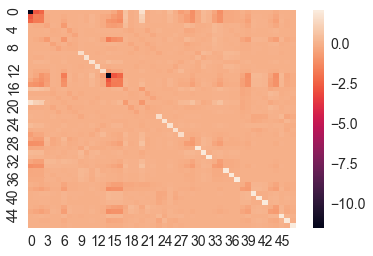

In [32]:
sns.heatmap(f_sad[0])

In [33]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_sad),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:25:48: Iteration calculation: 0
[ ] 2018-10-11 19:25:49: Iteration calculation: 1
[ ] 2018-10-11 19:25:49: Iteration calculation: 2
[ ] 2018-10-11 19:25:49: Iteration calculation: 3
[ ] 2018-10-11 19:25:50: Iteration calculation: 4
[ ] 2018-10-11 19:25:50: Iteration calculation: 5
[ ] 2018-10-11 19:25:50: Iteration calculation: 6
[ ] 2018-10-11 19:25:51: Iteration calculation: 7
[ ] 2018-10-11 19:25:51: Iteration calculation: 8
[ ] 2018-10-11 19:25:52: Iteration calculation: 9
[ ] 2018-10-11 19:25:52: Iteration calculation: 10
[ ] 2018-10-11 19:25:52: Iteration calculation: 11
[ ] 2018-10-11 19:25:53: Iteration calculation: 12
[ ] 2018-10-11 19:25:53: Iteration calculation: 13
[ ] 2018-10-11 19:25:53: Iteration calculation: 14
[ ] 2018-10-11 19:25:54: Iteration calculation: 15
[ ] 2018-10-11 19:25:54: Iteration calculation: 16
[ ] 2018-10-11 19:25:54: Iteration calculation: 17
[ ] 2018-10-11 19:25:55: Iteration calculation: 18
[ ] 2018-10-11 19:25:55: Iteration calcul

## Embedded SAD

In [34]:
f_embedded_sad = embedd_batch(f_sad)

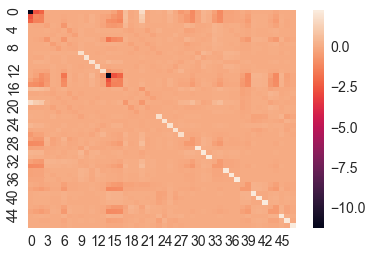

In [35]:
sns.heatmap(f_embedded_sad[0])

In [36]:
p_embedded_sad = density_from_fock_batch(f_embedded_sad)

In [37]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:26:35: Iteration calculation: 0
[ ] 2018-10-11 19:26:36: Iteration calculation: 1
[ ] 2018-10-11 19:26:36: Iteration calculation: 2
[ ] 2018-10-11 19:26:36: Iteration calculation: 3
[ ] 2018-10-11 19:26:37: Iteration calculation: 4
[ ] 2018-10-11 19:26:37: Iteration calculation: 5
[ ] 2018-10-11 19:26:37: Iteration calculation: 6
[ ] 2018-10-11 19:26:37: Iteration calculation: 7
[ ] 2018-10-11 19:26:38: Iteration calculation: 8
[ ] 2018-10-11 19:26:38: Iteration calculation: 9
[ ] 2018-10-11 19:26:39: Iteration calculation: 10
[ ] 2018-10-11 19:26:39: Iteration calculation: 11
[ ] 2018-10-11 19:26:39: Iteration calculation: 12
[ ] 2018-10-11 19:26:40: Iteration calculation: 13
[ ] 2018-10-11 19:26:40: Iteration calculation: 14
[ ] 2018-10-11 19:26:40: Iteration calculation: 15
[ ] 2018-10-11 19:26:41: Iteration calculation: 16
[ ] 2018-10-11 19:26:41: Iteration calculation: 17
[ ] 2018-10-11 19:26:41: Iteration calculation: 18
[ ] 2018-10-11 19:26:42: Iteration calcul

# McWheeny

In [38]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
s_test_batch = make_matrix_batch(S[ind:], dim)

In [39]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test_batch):
        p_res.append(multi_mc_wheeny(p, s, 5))
    return np.asarray(p_res)

### GWH

In [40]:
p_embedded_gwh_mcw5 = multi_mc_wheeny_batch(p_embedded_gwh)

In [41]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:27:14: Iteration calculation: 0
[ ] 2018-10-11 19:27:14: Iteration calculation: 1
[ ] 2018-10-11 19:27:15: Iteration calculation: 2
[ ] 2018-10-11 19:27:15: Iteration calculation: 3
[ ] 2018-10-11 19:27:15: Iteration calculation: 4
[ ] 2018-10-11 19:27:16: Iteration calculation: 5
[ ] 2018-10-11 19:27:16: Iteration calculation: 6
[ ] 2018-10-11 19:27:16: Iteration calculation: 7
[ ] 2018-10-11 19:27:17: Iteration calculation: 8
[ ] 2018-10-11 19:27:17: Iteration calculation: 9
[ ] 2018-10-11 19:27:17: Iteration calculation: 10
[ ] 2018-10-11 19:27:18: Iteration calculation: 11
[ ] 2018-10-11 19:27:18: Iteration calculation: 12
[ ] 2018-10-11 19:27:19: Iteration calculation: 13
[ ] 2018-10-11 19:27:19: Iteration calculation: 14
[ ] 2018-10-11 19:27:19: Iteration calculation: 15
[ ] 2018-10-11 19:27:20: Iteration calculation: 16
[ ] 2018-10-11 19:27:20: Iteration calculation: 17
[ ] 2018-10-11 19:27:20: Iteration calculation: 18
[ ] 2018-10-11 19:27:21: Iteration calcul

### SAP 

In [42]:
p_embedded_sap_mcw5 = multi_mc_wheeny_batch(p_embedded_sad)

In [43]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_sap_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 19:28:04: Iteration calculation: 0
[ ] 2018-10-11 19:28:05: Iteration calculation: 1
[ ] 2018-10-11 19:28:05: Iteration calculation: 2
[ ] 2018-10-11 19:28:05: Iteration calculation: 3
[ ] 2018-10-11 19:28:06: Iteration calculation: 4
[ ] 2018-10-11 19:28:06: Iteration calculation: 5
[ ] 2018-10-11 19:28:06: Iteration calculation: 6
[ ] 2018-10-11 19:28:07: Iteration calculation: 7
[ ] 2018-10-11 19:28:07: Iteration calculation: 8
[ ] 2018-10-11 19:28:07: Iteration calculation: 9
[ ] 2018-10-11 19:28:07: Iteration calculation: 10
[ ] 2018-10-11 19:28:08: Iteration calculation: 11
[ ] 2018-10-11 19:28:08: Iteration calculation: 12
[ ] 2018-10-11 19:28:09: Iteration calculation: 13
[ ] 2018-10-11 19:28:09: Iteration calculation: 14
[ ] 2018-10-11 19:28:09: Iteration calculation: 15
[ ] 2018-10-11 19:28:09: Iteration calculation: 16
[ ] 2018-10-11 19:28:10: Iteration calculation: 17
[ ] 2018-10-11 19:28:10: Iteration calculation: 18
[ ] 2018-10-11 19:28:11: Iteration calcul